# Project: No-Show Appointment Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> In this project we'll be analysing data associated with medical Appointment system.
> In Particular, we'll be interested in detecting whether the patient will attend the appointment or not. 
> This data  set was taken from 100k medical appointments in Brazil. Each row corresponds to a patient containing some information about him such as:
> - Gender
> - ScheduledDay
> - AppointmentDay
> - Age
> - Neighbourhood : indicates the location of the hospital 
> - Scholarship  : indicates whether or not the patient is enrolled in Brasilian welfare program   
> - Hipertension   
> - Diabetes        
> - Alcoholism   
> - Handcap        
> - SMS_received    
> - No-show : means if the patient attended the appointemnt or not         

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import Helper
%matplotlib inline 

<a id='wrangling'></a>
## Data Wrangling

In [30]:
# Load your data and print out a few lines. Perform operations to inspect data
noshow_appointment_df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
noshow_appointment_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [31]:
# to know number of rows and columns
noshow_appointment_df.shape

(110527, 14)

In [32]:
# know more details about data types
print(noshow_appointment_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
None


In [33]:
# check for missing values
noshow_appointment_df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [34]:
#invetigate age for checking strange values such as values less than 1
noshow_appointment_df['Age'].value_counts(dropna='False')

 0      3539
 1      2273
 52     1746
 49     1652
 53     1651
        ... 
 115       5
 100       4
 102       2
 99        1
-1         1
Name: Age, Length: 104, dtype: int64

In [35]:
#check if there is a strange value example: Y instead of Yes
noshow_appointment_df['No-show'].unique()

array(['No', 'Yes'], dtype=object)

In [36]:
noshow_appointment_df['Neighbourhood'].describe()

count             110527
unique                81
top       JARDIM CAMBURI
freq                7717
Name: Neighbourhood, dtype: object

In [37]:
#Check Duplicates
#Check Row Duplicates
print('----------------Check Row Duplicates---------------')
print(sum(noshow_appointment_df.duplicated()))
#Check If the same patient used twice in the data set
print('----------------Check If the same patient used twice in the data set---------------')
print(sum(noshow_appointment_df['PatientId'].duplicated()))

----------------Check Row Duplicates---------------
0
----------------Check If the same patient used twice in the data set---------------
48228


### Data Cleaning 

<dt> Now after some investigations we need to make some changes: </dt>
<dd> 1) change Handcap column name to Handicap --> spelling mistake </dd>
<dd> 2) remove column "PatientId" since the info it contains not useful </dd>
<dd> 3) change columns "ScheduledDay" and "AppointmentDay" to datetime format </dd>
<dd> 4) create a column for checking wether the patient appointment within a week from the schedule day, I anticipate that appointment made in short time will have higher turnout </dd>
<dd> 5)delete rows with age values less than 1 </dd>

In [38]:
# copy the df before operating
new_noshow_appointment_df = noshow_appointment_df.copy()

In [39]:
#change Handcap column name to Handicap
new_noshow_appointment_df.rename(columns = {'Handcap':'Handicap'}, inplace = True)
#confirm the change
new_noshow_appointment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handicap        110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [40]:
# clean from duplicates patients
new_noshow_appointment_df.drop_duplicates(subset='PatientId',inplace=True)
#confirm the drop
new_noshow_appointment_df.shape

(62299, 14)

In [41]:
#convert day to datetime 
new_noshow_appointment_df['ScheduledDay'] = Helper.parse_to_date(new_noshow_appointment_df['ScheduledDay'])
new_noshow_appointment_df['AppointmentDay'] = Helper.parse_to_date(new_noshow_appointment_df['AppointmentDay'])

#confirm the change
new_noshow_appointment_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62299 entries, 0 to 110524
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   PatientId       62299 non-null  float64            
 1   AppointmentID   62299 non-null  int64              
 2   Gender          62299 non-null  object             
 3   ScheduledDay    62299 non-null  datetime64[ns, UTC]
 4   AppointmentDay  62299 non-null  datetime64[ns, UTC]
 5   Age             62299 non-null  int64              
 6   Neighbourhood   62299 non-null  object             
 7   Scholarship     62299 non-null  int64              
 8   Hipertension    62299 non-null  int64              
 9   Diabetes        62299 non-null  int64              
 10  Alcoholism      62299 non-null  int64              
 11  Handicap        62299 non-null  int64              
 12  SMS_received    62299 non-null  int64              
 13  No-show         62299 non-null

In [42]:
#create time-out column for detecting wether the patient make appointment in the same week
new_noshow_appointment_df['Within_week'] = ((new_noshow_appointment_df['AppointmentDay'] -
                                            new_noshow_appointment_df['ScheduledDay']).dt.days <= 7).astype(int)

#check for creation
new_noshow_appointment_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 62299 entries, 0 to 110524
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   PatientId       62299 non-null  float64            
 1   AppointmentID   62299 non-null  int64              
 2   Gender          62299 non-null  object             
 3   ScheduledDay    62299 non-null  datetime64[ns, UTC]
 4   AppointmentDay  62299 non-null  datetime64[ns, UTC]
 5   Age             62299 non-null  int64              
 6   Neighbourhood   62299 non-null  object             
 7   Scholarship     62299 non-null  int64              
 8   Hipertension    62299 non-null  int64              
 9   Diabetes        62299 non-null  int64              
 10  Alcoholism      62299 non-null  int64              
 11  Handicap        62299 non-null  int64              
 12  SMS_received    62299 non-null  int64              
 13  No-show         62299 non-null

In [43]:
# drop ages less than 1 as it will be invalid 
new_noshow_appointment_df.drop(new_noshow_appointment_df[new_noshow_appointment_df['Age'] < 1].index, inplace = True)
#check if dropped 
new_noshow_appointment_df['Age'].value_counts(dropna='False')


1      1443
2      1074
3       966
5       919
52      913
       ... 
98        4
100       3
102       2
115       2
99        1
Name: Age, Length: 102, dtype: int64

<a id='eda'></a>
## Exploratory Data Analysis

### ## What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment? 

<a id='eda'></a>
## Exploring each column

array([[<AxesSubplot:xlabel='PatientId', ylabel='PatientId'>,
        <AxesSubplot:xlabel='AppointmentID', ylabel='PatientId'>,
        <AxesSubplot:xlabel='Age', ylabel='PatientId'>,
        <AxesSubplot:xlabel='Scholarship', ylabel='PatientId'>,
        <AxesSubplot:xlabel='Hipertension', ylabel='PatientId'>,
        <AxesSubplot:xlabel='Diabetes', ylabel='PatientId'>,
        <AxesSubplot:xlabel='Alcoholism', ylabel='PatientId'>,
        <AxesSubplot:xlabel='Handicap', ylabel='PatientId'>,
        <AxesSubplot:xlabel='SMS_received', ylabel='PatientId'>,
        <AxesSubplot:xlabel='Within_week', ylabel='PatientId'>],
       [<AxesSubplot:xlabel='PatientId', ylabel='AppointmentID'>,
        <AxesSubplot:xlabel='AppointmentID', ylabel='AppointmentID'>,
        <AxesSubplot:xlabel='Age', ylabel='AppointmentID'>,
        <AxesSubplot:xlabel='Scholarship', ylabel='AppointmentID'>,
        <AxesSubplot:xlabel='Hipertension', ylabel='AppointmentID'>,
        <AxesSubplot:xlabel='Diabetes',

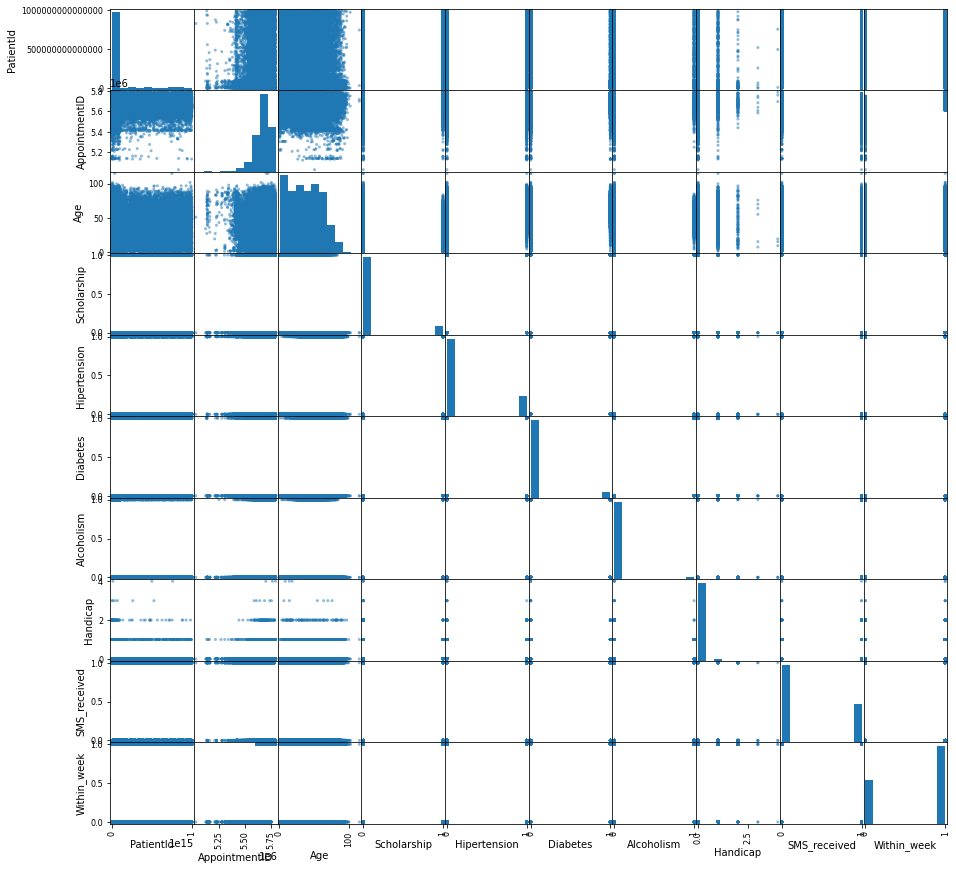

In [44]:
#exploring the data
pd.plotting.scatter_matrix(new_noshow_appointment_df,figsize=(15,15))

In [45]:
# invistigate deeper in each column
new_noshow_appointment_df['Gender'].value_counts(dropna='False')

F    39060
M    21165
Name: Gender, dtype: int64

<AxesSubplot:title={'center':'number of not shown patients female and male'}, ylabel='Gender'>

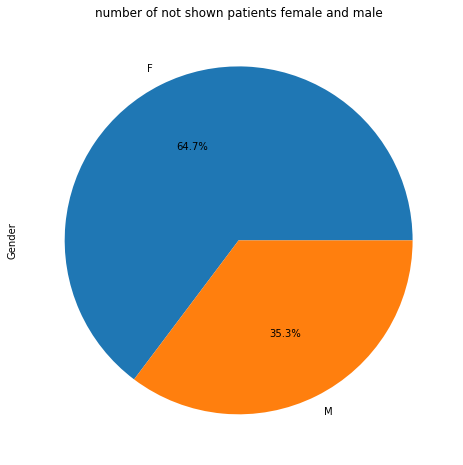

In [46]:
#check if gender affects in not shown patient
df_noshown_up = new_noshow_appointment_df[new_noshow_appointment_df['No-show'] == 'Yes']
df_noshown_up['Gender'].value_counts().plot(kind='pie',title="number of not shown patients female and male"
                                            ,autopct='%1.1f%%',figsize=(8,8))

In [47]:
df_noshown_up['Gender'].value_counts()

F    7639
M    4161
Name: Gender, dtype: int64

> the not attended patients most of them (around 64.7%) are female.

<AxesSubplot:title={'center':'number of not shown patients with age ranges'}>

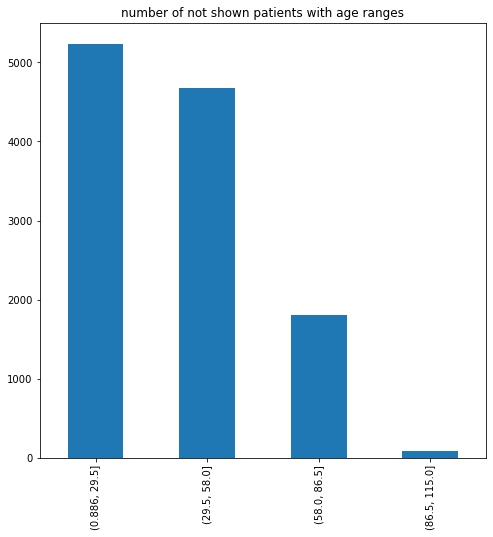

In [48]:
#exploring age column first group age to 4 groups
bins = pd.cut(df_noshown_up['Age'], bins=4,ordered = True,labels=['(0.886, 29.5]','(29.5, 58.0]','(58.0, 86.5]'
                                                                  ,'(86.5, 115.0]'])
bins.value_counts().plot(kind='bar',title="number of not shown patients with age ranges",figsize=(8,8))


In [49]:
dff_No = new_noshow_appointment_df[new_noshow_appointment_df['No-show'] == 'No']


<AxesSubplot:title={'center':'number of attended patients with age ranges'}>

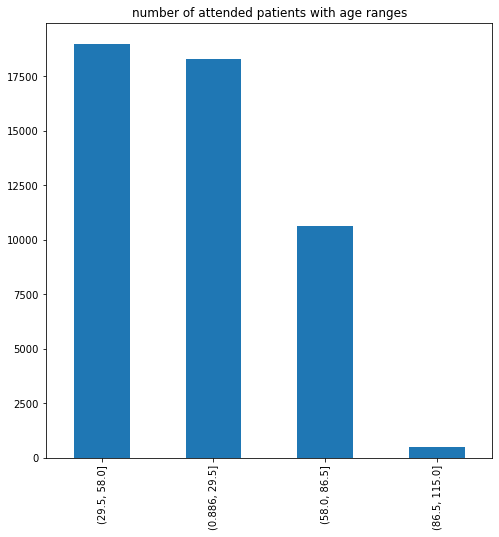

In [50]:
bins = pd.cut(dff_No['Age'], bins=4,ordered = True,labels=['(0.886, 29.5]','(29.5, 58.0]','(58.0, 86.5]',
                                                                  '(86.5, 115.0]'])
bins.value_counts().plot(kind='bar',title="number of attended patients with age ranges",figsize=(8,8))


>seems that the age effect for attending the appointment is not huge effect

In [51]:
new_noshow_appointment_df['Neighbourhood'].value_counts(dropna='False')

JARDIM CAMBURI                 4116
MARIA ORTIZ                    3212
JARDIM DA PENHA                2389
RESISTÊNCIA                    2259
ITARARÉ                        2068
                               ... 
ILHA DO BOI                      22
AEROPORTO                         7
ILHA DO FRADE                     5
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: Neighbourhood, Length: 81, dtype: int64

<AxesSubplot:title={'center':'number of not shown patients in each hospital'}>

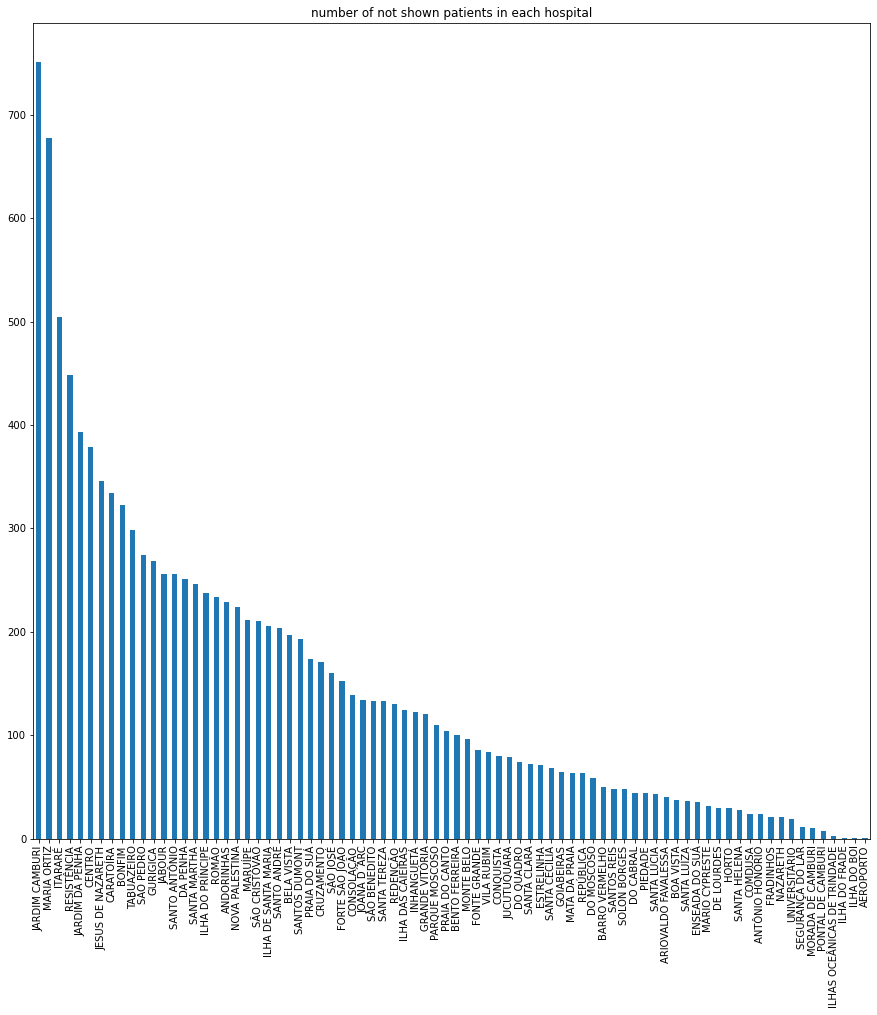

In [52]:
df_noshown_up['Neighbourhood'].value_counts().plot(kind='bar',title="number of not shown patients in each hospital",
                                                   figsize=(15,15))


<AxesSubplot:title={'center':'number of shown patients in each hospital'}>

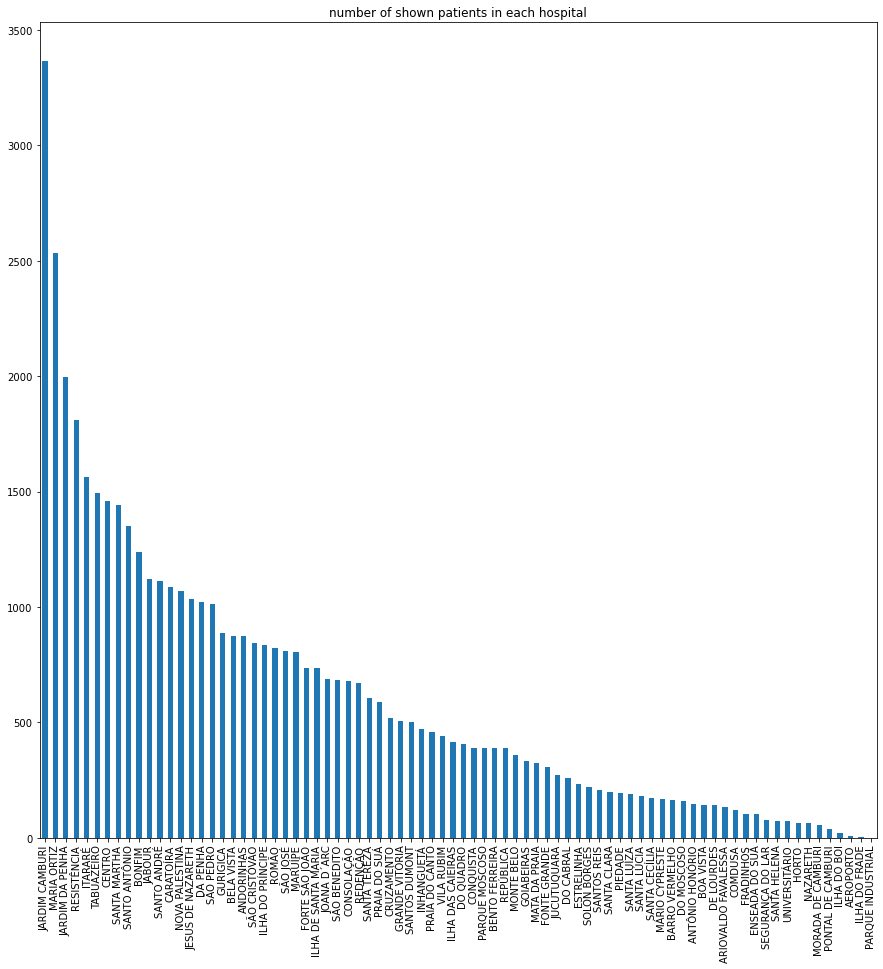

In [53]:
dff_No['Neighbourhood'].value_counts().plot(kind='bar',title="number of shown patients in each hospital",
                                            figsize=(15,15))


>From 2 previous diagrams seems that the hospital hasn't a strong effect in the patient appointment attendance

In [55]:
new_noshow_appointment_df['Diabetes'].value_counts(dropna='False')

0    55809
1     4416
Name: Diabetes, dtype: int64

In [56]:
new_noshow_appointment_df['Alcoholism'].value_counts(dropna='False')

0    58719
1     1506
Name: Alcoholism, dtype: int64

In [57]:
new_noshow_appointment_df['Handicap'].value_counts(dropna='False')

0    59093
1     1024
2       99
3        6
4        3
Name: Handicap, dtype: int64

In [58]:
new_noshow_appointment_df['No-show'].value_counts(dropna='False')

No     48425
Yes    11800
Name: No-show, dtype: int64

In [59]:
#find more effective column in the not shown up patient case
new_noshow_appointment_df.groupby(['No-show']).sum()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,Within_week
No-show,,,,,,,,,,
No,7.120885e+18,274650726433,1874026,4455,10223,3656,1160,1044,14475,33479
Yes,1.734647e+18,66538818916,412653,1302,2019,760,346,208,5350,4997


<AxesSubplot:title={'center':'number of not shown patients has Scholarship'}, ylabel='Scholarship'>

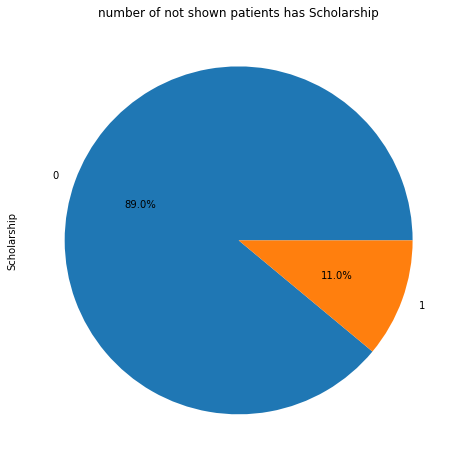

In [60]:
df_noshown_up['Scholarship'].value_counts().plot(kind='pie',title="number of not shown patients has Scholarship",
                                                 autopct='%1.1f%%',figsize=(8,8))

<AxesSubplot:title={'center':'patients not shown with handicap'}, xlabel='Handicap'>

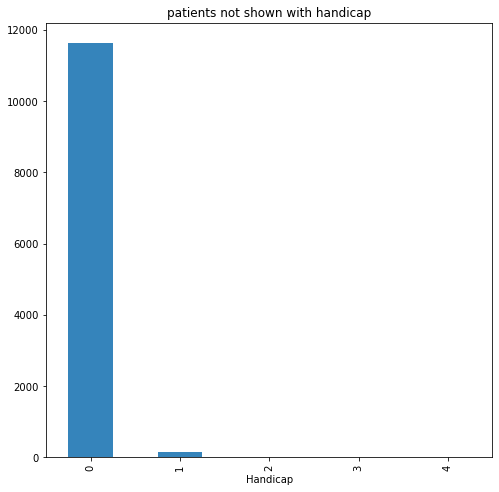

In [61]:
counts = df_noshown_up.groupby(['Handicap']).count()['No-show']
counts.plot(kind='bar',figsize=(8,8),title='patients not shown with handicap',alpha=.9)


In [62]:
new_noshow_appointment_df['SMS_received'].value_counts(dropna='False')

0    40400
1    19825
Name: SMS_received, dtype: int64

<AxesSubplot:title={'center':'number of not shown patients has received SMS'}, ylabel='SMS_received'>

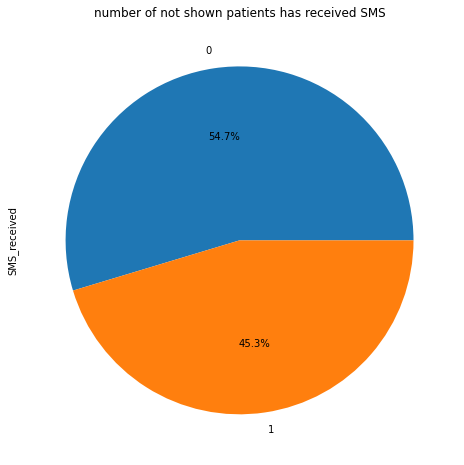

In [63]:
df_noshown_up['SMS_received'].value_counts().plot(kind='pie',title="number of not shown patients has received SMS"
                                                  ,autopct='%1.1f%%',figsize=(8,8))


In [64]:
df_noshown_up['SMS_received'].value_counts()

0    6450
1    5350
Name: SMS_received, dtype: int64

>seems that around (54.7%) of not attended patients didn't recieve an SMS

<AxesSubplot:title={'center':'number of not shown patients has scheduled                                                 appointment within week'}, ylabel='Within_week'>

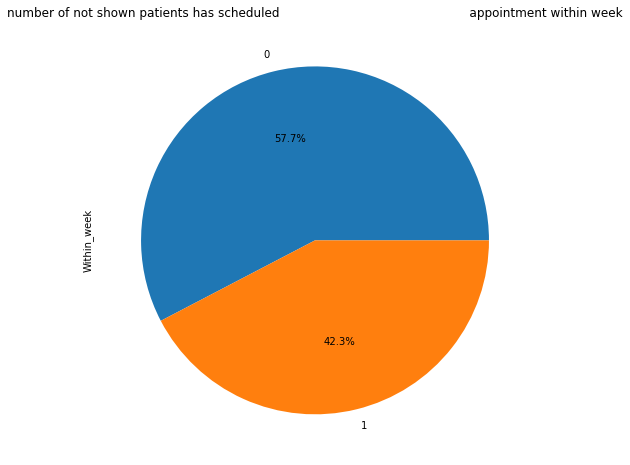

In [65]:
df_noshown_up['Within_week'].value_counts().plot(kind='pie',title="number of not shown patients has scheduled\
                                                 appointment within week",autopct='%1.1f%%',figsize=(8,8))


In [66]:
df_noshown_up['Within_week'].value_counts()

0    6803
1    4997
Name: Within_week, dtype: int64

> seems that most of not attended patients scheduled appointment after a week (57.7%)

[Text(0, 0, 'No chronic disease & Scholarship'),
 Text(1, 0, 'has only handicap level 1'),
 Text(2, 0, 'has only handicap level 2'),
 Text(3, 0, 'has only handicap level 3'),
 Text(4, 0, 'has only handicap level 4'),
 Text(5, 0, 'has only Alcoholism'),
 Text(6, 0, 'has Alcoholism & handicap level 1'),
 Text(7, 0, 'has Alcoholism & handicap level 2'),
 Text(8, 0, 'has only Diabetes'),
 Text(9, 0, 'has Diabetes & handicap level 1'),
 Text(10, 0, 'has Diabetes & Alcoholism'),
 Text(11, 0, 'has Diabetes & Alcoholism & handicap level 1'),
 Text(12, 0, 'has only Hipertension'),
 Text(13, 0, 'has Hipertension & handicap level 1'),
 Text(14, 0, 'has Hipertension & handicap level 2'),
 Text(15, 0, 'has Hipertension & handicap level 3'),
 Text(16, 0, 'has Hipertension & Alcoholism'),
 Text(17, 0, 'has Hipertension & Diabetes'),
 Text(18, 0, 'has Hipertension, Diabetes & handicap level 1'),
 Text(19, 0, 'has Hipertension, Diabetes & handicap level 2'),
 Text(20, 0, 'has Hipertension, Diabetes & A

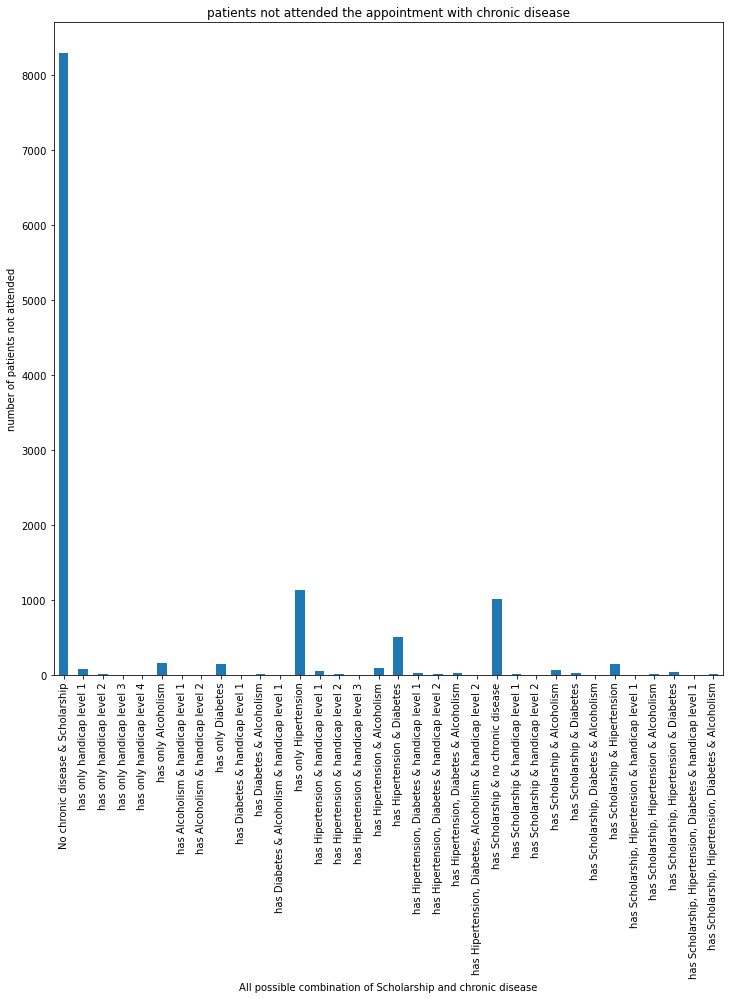

In [67]:
counts = df_noshown_up.groupby(['Scholarship','Hipertension','Diabetes','Alcoholism','Handicap']).count()['No-show']
x_labels = ['No chronic disease & Scholarship','has only handicap level 1','has only handicap level 2'
            ,'has only handicap level 3','has only handicap level 4','has only Alcoholism',
            'has Alcoholism & handicap level 1','has Alcoholism & handicap level 2','has only Diabetes',
            'has Diabetes & handicap level 1','has Diabetes & Alcoholism',
            'has Diabetes & Alcoholism & handicap level 1','has only Hipertension',
            'has Hipertension & handicap level 1','has Hipertension & handicap level 2',
            'has Hipertension & handicap level 3','has Hipertension & Alcoholism',
            'has Hipertension & Diabetes','has Hipertension, Diabetes & handicap level 1',
            'has Hipertension, Diabetes & handicap level 2','has Hipertension, Diabetes & Alcoholism',
            'has Hipertension, Diabetes, Alcoholism & handicap level 2','has Scholarship & no chronic disease',
            'has Scholarship & handicap level 1','has Scholarship & handicap level 2','has Scholarship & Alcoholism',
            'has Scholarship & Diabetes','has Scholarship, Diabetes & Alcoholism','has Scholarship & Hipertension',
            'has Scholarship, Hipertension & handicap level 1','has Scholarship, Hipertension & Alcoholism',
            'has Scholarship, Hipertension & Diabetes','has Scholarship, Hipertension, Diabetes & handicap level 1',
            'has Scholarship, Hipertension, Diabetes & Alcoholism']
plt.figure(figsize=(12, 12))
ax = counts.plot(kind='bar')
ax.set_title('patients not attended the appointment with chronic disease')
ax.set_xlabel('All possible combination of Scholarship and chronic disease')
ax.set_ylabel('number of patients not attended')
ax.set_xticklabels(x_labels)

>with exploring the not attended patients' attributes related to chronic disease and scholarship we notice that the patients don't have chronic disease and scholarship don't attend the appointment

<a id='conclusions'></a>
## Conclusions

<dt> At the end, the target to focus on the question of whether or not patients show up for their appointment and our data shows that: </dt>
<dd> 1) Most of not attended patients don't have a chronic disease and Scholarship and this is the most effective values in all atributes </dd>
<dd> 2) Not attended patients most of them didn't recieve an SMS around (55%) </dd>
<dd> 3) Not attended patients most of them scheduled appointment after a week around (58%) </dd>
<dd> 4) Not attended patients around (65%) are female </dd>
<dt> However, There is some limitations: </dt>
In this dataset I can not provide more detials example that location of the hospitals 'Neighbourhood' is limited as the highest data provided for a hospital is 4192 from around min 62299 so I can not exactly determine for each location of the hospital if a patient will show up or not.